<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Tutorial/3-Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning with coral reef soundscape data**

This notebook is a supporting tutorial for the study **Unlocking the soundscape of coral reefs with artificial intelligence** by [Williams et al (2024a)](https://www.biorxiv.org/content/10.1101/2024.02.02.578582v1). If you use any of these methods after reading this then please cite the article.

In this publication we recommend combining pretrained neural networks with unsupervised learning for analysing soundscape ecology.


What this notebook does:
1. Use UMAP to explore data qualitatively.
2. Use UMAP to reduce dimensions of data and then train an unsupervised clustering algorithm to explore data quantitatively.






# **Step 1: Set up**

First, lets mount our Google Drive again.

## Install UMAP
UMAP is not a standard package on Colab so we need to start by installing it. This is typically using the terminal. We can use an '!' before code to run it as a terminal command.

In [63]:
import umap
import os # for handling files and directories
import librosa # for audio processing
import tensorflow as tf # for machine learning
import tensorflow_hub as hub # for machine learning
import numpy as np # for numerical processing
import pandas as pd # for handling dataframes
from tqdm import tqdm # for progress bar
import matplotlib.pyplot as plt # for potting
from sklearn.cluster import KMeans # for clustering
from chirp.inference import tf_examples


# To get reproducabel results, we set the seed
random_seed = 42

In [64]:
# Path to the directory containing the TFRecord files
tfrecord_dir  = '/mnt/d/Aqoustics/BEN/Indonesia_Embeddings/'

# Path where we will save an updated version of features_df, with added metadata
features_metadata_path = '/mnt/d/Aqoustics/BEN/Indonesia_Embeddings/reduced_feature_embeddings.csv'

# Path where we will save cluster results
cluster_results_path = '/mnt/d/Aqoustics/BEN/Indonesia_Embeddings/cluster_results.csv'

In [65]:
import os

def list_files_in_folder(folder_path):
    """
    Returns a list of all files in the given folder path.

    Parameters:
    folder_path (str): The path to the folder.

    Returns:
    List[str]: A list of file names in the folder.
    """
    # Check if the folder path exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

    # List all files in the folder (excluding directories)
    files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

    return files


In [66]:
file_list = list_files_in_folder(tfrecord_dir)
file_list

['config.json',
 'embeddings-1728921439-00000-of-00100',
 'embeddings-1728921439-00001-of-00100',
 'embeddings-1728921439-00002-of-00100',
 'embeddings-1728921439-00003-of-00100',
 'embeddings-1728921439-00004-of-00100',
 'embeddings-1728921439-00005-of-00100',
 'embeddings-1728921439-00006-of-00100',
 'embeddings-1728921439-00007-of-00100',
 'embeddings-1728921439-00008-of-00100',
 'embeddings-1728921439-00009-of-00100',
 'embeddings-1728921439-00010-of-00100',
 'embeddings-1728921439-00011-of-00100',
 'embeddings-1728921439-00012-of-00100',
 'embeddings-1728921439-00013-of-00100',
 'embeddings-1728921439-00014-of-00100',
 'embeddings-1728921439-00015-of-00100',
 'embeddings-1728921439-00016-of-00100',
 'embeddings-1728921439-00017-of-00100',
 'embeddings-1728921439-00018-of-00100',
 'embeddings-1728921439-00019-of-00100',
 'embeddings-1728921439-00020-of-00100',
 'embeddings-1728921439-00021-of-00100',
 'embeddings-1728921439-00022-of-00100',
 'embeddings-1728921439-00023-of-00100',


In [67]:
file_list.remove('reduced_feature_embeddings.csv')

In [68]:
file_list.remove('config.json')

In [69]:
file_list = ['embeddings-1728921439-00000-of-00100', 'embeddings-1728921439-00001-of-00100']

In [70]:
def read_embeddings_to_dataframe(tfrecord_files):
    # Initialize empty lists to store filenames and embeddings
    filenames = []
    embeddings = []

    # Loop through the list of TFRecord files
    for tfrecord_file in tfrecord_files:
        # Create a TFRecordDataset from the current TFRecord file
        ds = tf.data.TFRecordDataset(tfrecord_file)

        # Use the example parser from tf_examples to parse the embeddings
        parser = tf_examples.get_example_parser()
        ds = ds.map(parser)

        # Iterate through the dataset and extract filenames and embeddings
        for ex in ds.as_numpy_iterator():
            filename = ex['filename'].decode("utf-8")  # Decode the byte string
            embedding = ex['embedding'].flatten()  # Flatten the embedding for easier handling
            filenames.append(filename)
            embeddings.append(embedding)

    # Convert the embeddings list to a DataFrame
    df = pd.DataFrame(embeddings)
    
    # Add the filenames as a separate column
    df['filename'] = filenames

    # Reorder columns to have 'filename' first
    df = df[['filename'] + [col for col in df.columns if col != 'filename']]

    return df

In [71]:
# Construct the full paths to the TFRecord files using file_list
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in file_list]

# Call the function to read embeddings and store them in a DataFrame
embeddings_df = read_embeddings_to_dataframe(tfrecord_files)


print(f"Embeddings DataFrame created with shape: {embeddings_df.shape}")

Embeddings DataFrame created with shape: (38641, 1281)


In [72]:
features_df = embeddings_df

### Take a peek at the features dataframe

Check it looks in order. Note each file was split into 5s samples, so we have the added 'embedding_index' column which denotes which sample of a longer file this row pertains to, e.g for a 60s file there will be 12 rows.

### Add further metadata to df

For now we will just add the class of site that the audio came from. This is healthy, degraded or restored.

In the sample data you can see each filename starts with an H, D or R corresponding to these classes. For your own data, you may wish to change these or add further meta data to the filename to be explored during analysis. You can save this in your filename (or use a seperate file to link filenames to classes) and then modify the cells below accordingly.

In [73]:
def extract_metadata_from_filename(file):
    # Split the filename using 'clip_ind_' as the delimiter
    parts = file.split('Indonesia_ROI/clip_ind_')
    
    # Extract the first letter after 'clip_ind_' to determine the class_type
    class_type = parts[1][0] if len(parts) > 1 else None
    
    return class_type


# Applying the function to each filename in the DataFrame
features_df['class_type'] = features_df['filename'].apply(extract_metadata_from_filename)

# Arrange columns in the desired order
# Here, embedding columns are likely represented by integers rather than starting with 'feature_'
column_order = ['filename', 'class_type'] + \
               [col for col in features_df.columns if isinstance(col, int)]  # Adjust this to match your actual column names

# Reorder the DataFrame
features_metadata_df = features_df[column_order]

# Save the DataFrame to a CSV file
#features_metadata_path = "path_to_save_metadata.csv"  # Replace this with your actual path
#features_metadata_df.to_csv(features_metadata_path, index=False)

# Display the DataFrame to check
features_metadata_df


,filename,class_type,0,1,2,3,4,5,6,7,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,Indonesia_ROI/clip_ind_D1_20220829_120000_0.wav,D,-0.027101,-0.076875,-0.063106,0.032776,-0.128390,0.136482,0.139281,-0.020360,...,-0.020906,-0.036628,0.089414,-0.059290,-0.013971,-0.010311,-0.015603,0.004040,0.004900,0.047447
1,Indonesia_ROI/clip_ind_D1_20220829_122600_0.wav,D,0.025823,-0.047014,-0.038703,0.030943,-0.154223,0.156452,0.229621,-0.040012,...,0.031698,0.087686,0.086208,-0.029191,-0.019122,0.027325,-0.125972,-0.025800,0.147274,0.028828
2,Indonesia_ROI/clip_ind_D1_20220829_130000_3.wav,D,0.076208,-0.006164,-0.071892,-0.009540,-0.164359,0.113579,0.255701,-0.009470,...,-0.016435,-0.027000,0.027038,-0.025422,-0.007529,0.013441,-0.091270,-0.008261,0.024753,0.020466
3,Indonesia_ROI/clip_ind_D1_20220829_133800_0.wav,D,-0.018631,-0.034017,-0.046339,-0.008619,-0.102244,0.154953,0.137440,-0.002801,...,-0.010675,-0.074416,0.032068,-0.019790,-0.015040,-0.000246,0.022408,-0.006491,-0.009394,0.036871
4,Indonesia_ROI/clip_ind_D1_20220829_141400_9.wav,D,0.051516,-0.037551,-0.027426,0.022241,-0.126988,0.112052,0.155293,0.006822,...,-0.015609,0.029606,0.245155,-0.011603,-0.022627,0.018287,0.009013,-0.033843,0.051912,0.028696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38636,Indonesia_ROI/clip_ind_R6_20220923_080600_4.wav,R,0.077676,0.010078,-0.065704,0.136801,-0.164885,0.094604,0.090499,-0.017165,...,0.061547,-0.022619,0.171708,-0.034550,-0.016161,0.011502,-0.114415,-0.038009,0.065512,0.038277
38637,Indonesia_ROI/clip_ind_R6_20220923_084000_0.wav,R,-0.009442,-0.019671,-0.073311,0.040517,-0.157533,0.139587,0.146487,-0.035328,...,0.015401,-0.068740,0.094621,-0.090992,-0.022261,0.014381,0.021919,-0.018332,0.045196,0.028759
38638,Indonesia_ROI/clip_ind_R6_20220923_085600_5.wav,R,-0.003106,-0.046812,-0.005686,0.019535,-0.178058,0.093484,0.228089,-0.037534,...,-0.031997,-0.014122,0.108430,-0.090925,-0.009980,0.013957,0.062566,-0.025443,0.011121,0.018234
38639,Indonesia_ROI/clip_ind_R6_20220923_092000_8.wav,R,0.081046,-0.041044,0.019907,0.081121,-0.121218,0.060793,0.078691,0.001169,...,0.039250,-0.089662,0.401369,-0.013633,-0.015444,0.012142,0.004426,-0.031607,0.107869,-0.001309


In [74]:
features_metadata_df.iloc[:, 2:]

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.027101,-0.076875,-0.063106,0.032776,-0.128390,0.136482,0.139281,-0.020360,-0.087556,-0.006063,...,-0.020906,-0.036628,0.089414,-0.059290,-0.013971,-0.010311,-0.015603,0.004040,0.004900,0.047447
1,0.025823,-0.047014,-0.038703,0.030943,-0.154223,0.156452,0.229621,-0.040012,-0.124491,-0.052891,...,0.031698,0.087686,0.086208,-0.029191,-0.019122,0.027325,-0.125972,-0.025800,0.147274,0.028828
2,0.076208,-0.006164,-0.071892,-0.009540,-0.164359,0.113579,0.255701,-0.009470,-0.067483,-0.041185,...,-0.016435,-0.027000,0.027038,-0.025422,-0.007529,0.013441,-0.091270,-0.008261,0.024753,0.020466
3,-0.018631,-0.034017,-0.046339,-0.008619,-0.102244,0.154953,0.137440,-0.002801,0.001976,-0.023902,...,-0.010675,-0.074416,0.032068,-0.019790,-0.015040,-0.000246,0.022408,-0.006491,-0.009394,0.036871
4,0.051516,-0.037551,-0.027426,0.022241,-0.126988,0.112052,0.155293,0.006822,-0.051022,0.038524,...,-0.015609,0.029606,0.245155,-0.011603,-0.022627,0.018287,0.009013,-0.033843,0.051912,0.028696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38636,0.077676,0.010078,-0.065704,0.136801,-0.164885,0.094604,0.090499,-0.017165,-0.096153,-0.124085,...,0.061547,-0.022619,0.171708,-0.034550,-0.016161,0.011502,-0.114415,-0.038009,0.065512,0.038277
38637,-0.009442,-0.019671,-0.073311,0.040517,-0.157533,0.139587,0.146487,-0.035328,-0.079420,-0.035438,...,0.015401,-0.068740,0.094621,-0.090992,-0.022261,0.014381,0.021919,-0.018332,0.045196,0.028759
38638,-0.003106,-0.046812,-0.005686,0.019535,-0.178058,0.093484,0.228089,-0.037534,-0.101389,-0.034235,...,-0.031997,-0.014122,0.108430,-0.090925,-0.009980,0.013957,0.062566,-0.025443,0.011121,0.018234
38639,0.081046,-0.041044,0.019907,0.081121,-0.121218,0.060793,0.078691,0.001169,-0.084988,-0.073494,...,0.039250,-0.089662,0.401369,-0.013633,-0.015444,0.012142,0.004426,-0.031607,0.107869,-0.001309


# **Step 2: UMAP visualisation**

Run UMAP to visualise the data. This compresses the features down to 2 dimensions so we can see a plot which produces groupings of similar sounding recordings.

For new data, you can try adjusting the n_neighbors and min_dist parameters and until you find a plot with a distibution of points that is most easily interpretable, e.g no huge or tiny gaps between clusters and points not all one ontop of each other or highly spread out.





In [75]:
import umap
n_neighbors = 13
min_dist = 0.1

In [76]:
sampled_data = features_metadata_df.sample(frac=0.05, random_state=random_seed)
sampled_data.iloc[:, 2:]

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
35893,0.086654,0.021585,-0.045637,-0.090137,-0.186226,0.055723,0.140683,-0.065617,-0.128814,0.043081,...,0.004221,0.023442,0.031173,-0.056005,0.011713,0.004856,-0.109457,-0.018838,0.058437,0.069464
27980,0.163935,0.103144,-0.008012,0.104664,-0.167045,0.088260,0.227708,-0.102003,-0.110513,-0.016611,...,-0.022704,-0.010150,0.014226,-0.074934,-0.005629,0.001117,-0.124102,-0.034625,0.162015,0.052478
38270,-0.014731,-0.001558,0.004292,-0.000156,-0.157762,0.029088,0.100256,-0.056023,-0.104004,-0.141445,...,0.000078,-0.051993,0.047501,-0.028271,-0.017643,0.022643,-0.035623,-0.033294,0.012104,0.019942
27462,0.141294,0.019360,0.004517,0.045389,-0.164965,0.038178,0.183685,-0.017793,-0.125210,-0.062852,...,-0.019467,-0.011657,0.055277,0.004631,-0.018674,0.039861,-0.023021,-0.034787,0.009101,0.030369
26783,0.006082,-0.025032,-0.021742,0.112648,-0.141162,0.130332,0.210001,-0.065286,-0.134833,-0.058172,...,-0.010504,0.025569,0.109338,0.008955,-0.008608,0.011786,-0.168010,-0.011138,0.082148,0.048903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30757,0.200559,0.015384,-0.060401,-0.040804,-0.176678,0.034978,0.188283,-0.038737,-0.147676,-0.086277,...,-0.017926,-0.016605,0.075812,0.002950,-0.015310,0.016496,-0.134251,-0.028581,0.135996,0.036632
28667,0.145969,0.009570,-0.043290,0.035550,-0.164793,0.034993,0.200173,-0.069178,-0.121933,-0.037244,...,0.005443,-0.008138,0.078721,-0.047793,-0.012750,0.018033,-0.148894,-0.022348,0.099281,0.046443
14660,0.040231,-0.019025,0.021880,0.140185,-0.105534,0.106617,0.192430,-0.014584,-0.134891,0.000339,...,0.009286,-0.075762,0.030391,0.009533,0.004585,0.042297,0.120637,-0.022112,-0.033281,0.032201
19145,0.001930,-0.042421,-0.063710,0.041710,-0.155384,0.096047,0.127171,-0.029746,-0.108160,-0.053768,...,-0.010523,-0.095621,0.189925,-0.037263,-0.016935,0.011717,0.025731,0.004003,0.031768,0.032539


In [77]:
umap_reducer = umap.UMAP(n_components=128, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
umap_reducer.fit(sampled_data.iloc[:, 2:])
reduced_features_128 = umap_reducer.transform(features_metadata_df.iloc[:, 2:])
umap_reducer_2d = umap.UMAP(n_components=2, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
reduced_features_2d = umap_reducer_2d.fit_transform(reduced_features_128)

/home/os/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/os/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


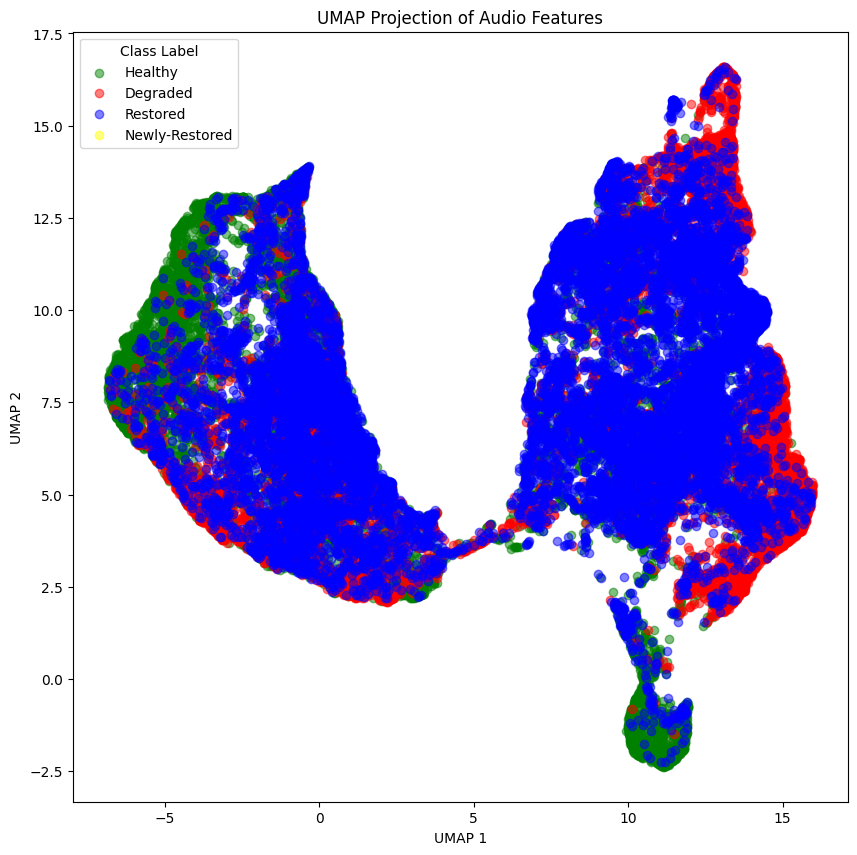

In [78]:
# Mapping from single letters to words for descriptive labels
class_mapping = {'H': 'Healthy', 'D': 'Degraded', 'R': 'Restored', 'N': 'Newly-Restored'}
color_mapping = {'Healthy': 'green', 'Degraded': 'red', 'Restored': 'blue', 'Newly-Restored' : 'yellow'}

# Set up the plot
plt.figure(figsize=(10, 10))

# Plot each class with its own color and label using the mapping
for class_type, label in class_mapping.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['class_type'] == class_type
    plt.scatter(reduced_features_2d[indices, 0], reduced_features_2d[indices, 1], label=label,
                color=color_mapping[label], alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection of Audio Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()

Shape of covariance matrices: [(2, 2), (2, 2)]
Shape of covariance matrices: [(2, 2), (2, 2)]


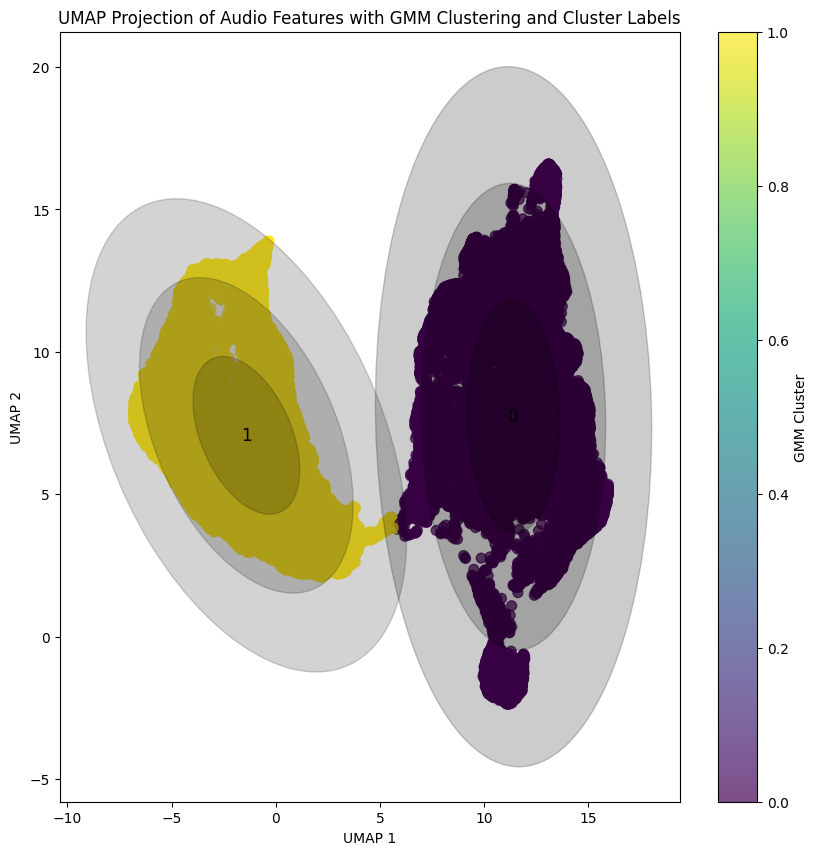

In [79]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Step 1: Fit GMM on the 2D UMAP embeddings
n_components = 2  # Set the number of clusters (you can adjust this based on your data)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_seed)
gmm.fit(reduced_features_2d)

# Step 2: Predict the cluster labels for each point
gmm_labels = gmm.predict(reduced_features_2d)

# Step 3: Function to draw ellipses representing GMM components
def draw_ellipse(position, covariance, ax=None, cluster_num=None, **kwargs):
    """Draw an ellipse with a given position and covariance and label it with the cluster number."""
    ax = ax or plt.gca()

    # Compute the eigenvalues and eigenvectors to find the axes of the ellipse
    if covariance.shape == (2, 2):
        eigvals, eigvecs = np.linalg.eigh(covariance)
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * np.sqrt(eigvals)
    else:
        raise ValueError("Covariance matrix must be 2x2 for 2D data.")

    # Draw the Ellipse with angle as a keyword argument
    for nsig in range(1, 4):  # Draw ellipses at 1, 2, and 3 standard deviations
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))

    # Add the cluster number at the center of the ellipse
    if cluster_num is not None:
        ax.text(position[0], position[1], str(cluster_num), color='black', fontsize=12, ha='center', va='center')


# Step 4: Plot UMAP embeddings with clusters from GMM
plt.figure(figsize=(10, 10))

# Plot UMAP embeddings and color them by the GMM cluster labels
plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=gmm_labels, cmap='viridis', s=50, alpha=0.7)

# Step 5: Plot GMM ellipses with cluster numbers
w_factor = 0.2 / gmm.weights_.max()  # Scale the ellipses by their weights
for i, (pos, covar, w) in enumerate(zip(gmm.means_, gmm.covariances_, gmm.weights_)):
    # Add this print statement before calling draw_ellipse
    print("Shape of covariance matrices:", [cov.shape for cov in gmm.covariances_])
    draw_ellipse(pos, covar, alpha=w * w_factor, color='black', cluster_num=i)  # Add cluster number

plt.title('UMAP Projection of Audio Features with GMM Clustering and Cluster Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='GMM Cluster')
plt.show()


In [80]:
features_metadata_df['cluster'] = gmm_labels
features_metadata_df

/tmp/ipykernel_77701/1460017180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_metadata_df['cluster'] = gmm_labels


,filename,class_type,0,1,2,3,4,5,6,7,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
0,Indonesia_ROI/clip_ind_D1_20220829_120000_0.wav,D,-0.027101,-0.076875,-0.063106,0.032776,-0.128390,0.136482,0.139281,-0.020360,...,-0.036628,0.089414,-0.059290,-0.013971,-0.010311,-0.015603,0.004040,0.004900,0.047447,0
1,Indonesia_ROI/clip_ind_D1_20220829_122600_0.wav,D,0.025823,-0.047014,-0.038703,0.030943,-0.154223,0.156452,0.229621,-0.040012,...,0.087686,0.086208,-0.029191,-0.019122,0.027325,-0.125972,-0.025800,0.147274,0.028828,1
2,Indonesia_ROI/clip_ind_D1_20220829_130000_3.wav,D,0.076208,-0.006164,-0.071892,-0.009540,-0.164359,0.113579,0.255701,-0.009470,...,-0.027000,0.027038,-0.025422,-0.007529,0.013441,-0.091270,-0.008261,0.024753,0.020466,0
3,Indonesia_ROI/clip_ind_D1_20220829_133800_0.wav,D,-0.018631,-0.034017,-0.046339,-0.008619,-0.102244,0.154953,0.137440,-0.002801,...,-0.074416,0.032068,-0.019790,-0.015040,-0.000246,0.022408,-0.006491,-0.009394,0.036871,0
4,Indonesia_ROI/clip_ind_D1_20220829_141400_9.wav,D,0.051516,-0.037551,-0.027426,0.022241,-0.126988,0.112052,0.155293,0.006822,...,0.029606,0.245155,-0.011603,-0.022627,0.018287,0.009013,-0.033843,0.051912,0.028696,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38636,Indonesia_ROI/clip_ind_R6_20220923_080600_4.wav,R,0.077676,0.010078,-0.065704,0.136801,-0.164885,0.094604,0.090499,-0.017165,...,-0.022619,0.171708,-0.034550,-0.016161,0.011502,-0.114415,-0.038009,0.065512,0.038277,1
38637,Indonesia_ROI/clip_ind_R6_20220923_084000_0.wav,R,-0.009442,-0.019671,-0.073311,0.040517,-0.157533,0.139587,0.146487,-0.035328,...,-0.068740,0.094621,-0.090992,-0.022261,0.014381,0.021919,-0.018332,0.045196,0.028759,0
38638,Indonesia_ROI/clip_ind_R6_20220923_085600_5.wav,R,-0.003106,-0.046812,-0.005686,0.019535,-0.178058,0.093484,0.228089,-0.037534,...,-0.014122,0.108430,-0.090925,-0.009980,0.013957,0.062566,-0.025443,0.011121,0.018234,0
38639,Indonesia_ROI/clip_ind_R6_20220923_092000_8.wav,R,0.081046,-0.041044,0.019907,0.081121,-0.121218,0.060793,0.078691,0.001169,...,-0.089662,0.401369,-0.013633,-0.015444,0.012142,0.004426,-0.031607,0.107869,-0.001309,0


In [81]:
features_metadata_df.columns


Index([  'filename', 'class_type',            0,            1,            2,
                  3,            4,            5,            6,            7,
       ...
               1271,         1272,         1273,         1274,         1275,
               1276,         1277,         1278,         1279,    'cluster'],
      dtype='object', length=1283)

In [82]:
def filter_by_cluster(df, cluster_numbers):
    """
    Remove rows from the DataFrame where the 'cluster' column matches any of the values in cluster_numbers list.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    cluster_numbers (list): A list of cluster values to remove from the DataFrame.
    
    Returns:
    pd.DataFrame: A new DataFrame with the specified clusters removed.
    """
    # Remove rows where the 'cluster' value is in the cluster_numbers list
    filtered_df = df[~df['cluster'].isin(cluster_numbers)]
    
    return filtered_df


clusters_to_remove = [1]

# Apply the filter function
filtered_df = filter_by_cluster(features_metadata_df, clusters_to_remove)

In [83]:
filtered_df

,filename,class_type,0,1,2,3,4,5,6,7,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
0,Indonesia_ROI/clip_ind_D1_20220829_120000_0.wav,D,-0.027101,-0.076875,-0.063106,0.032776,-0.128390,0.136482,0.139281,-0.020360,...,-0.036628,0.089414,-0.059290,-0.013971,-0.010311,-0.015603,0.004040,0.004900,0.047447,0
2,Indonesia_ROI/clip_ind_D1_20220829_130000_3.wav,D,0.076208,-0.006164,-0.071892,-0.009540,-0.164359,0.113579,0.255701,-0.009470,...,-0.027000,0.027038,-0.025422,-0.007529,0.013441,-0.091270,-0.008261,0.024753,0.020466,0
3,Indonesia_ROI/clip_ind_D1_20220829_133800_0.wav,D,-0.018631,-0.034017,-0.046339,-0.008619,-0.102244,0.154953,0.137440,-0.002801,...,-0.074416,0.032068,-0.019790,-0.015040,-0.000246,0.022408,-0.006491,-0.009394,0.036871,0
4,Indonesia_ROI/clip_ind_D1_20220829_141400_9.wav,D,0.051516,-0.037551,-0.027426,0.022241,-0.126988,0.112052,0.155293,0.006822,...,0.029606,0.245155,-0.011603,-0.022627,0.018287,0.009013,-0.033843,0.051912,0.028696,0
5,Indonesia_ROI/clip_ind_D1_20220829_144600_1.wav,D,0.086814,0.007364,0.039778,-0.016533,-0.109143,0.084214,0.151655,0.015705,...,-0.037960,0.231141,-0.052879,-0.014241,0.000537,0.099127,-0.040683,0.074440,0.010627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38635,Indonesia_ROI/clip_ind_R6_20220923_074200_5.wav,R,0.026358,-0.009309,-0.049600,0.065156,-0.152420,0.139925,0.110636,-0.005117,...,-0.098897,0.188489,-0.041181,0.009082,0.012071,0.031566,-0.013771,0.138063,0.049329,0
38637,Indonesia_ROI/clip_ind_R6_20220923_084000_0.wav,R,-0.009442,-0.019671,-0.073311,0.040517,-0.157533,0.139587,0.146487,-0.035328,...,-0.068740,0.094621,-0.090992,-0.022261,0.014381,0.021919,-0.018332,0.045196,0.028759,0
38638,Indonesia_ROI/clip_ind_R6_20220923_085600_5.wav,R,-0.003106,-0.046812,-0.005686,0.019535,-0.178058,0.093484,0.228089,-0.037534,...,-0.014122,0.108430,-0.090925,-0.009980,0.013957,0.062566,-0.025443,0.011121,0.018234,0
38639,Indonesia_ROI/clip_ind_R6_20220923_092000_8.wav,R,0.081046,-0.041044,0.019907,0.081121,-0.121218,0.060793,0.078691,0.001169,...,-0.089662,0.401369,-0.013633,-0.015444,0.012142,0.004426,-0.031607,0.107869,-0.001309,0


In [84]:
filtered_df.iloc[:, 2:-1]

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.027101,-0.076875,-0.063106,0.032776,-0.128390,0.136482,0.139281,-0.020360,-0.087556,-0.006063,...,-0.020906,-0.036628,0.089414,-0.059290,-0.013971,-0.010311,-0.015603,0.004040,0.004900,0.047447
2,0.076208,-0.006164,-0.071892,-0.009540,-0.164359,0.113579,0.255701,-0.009470,-0.067483,-0.041185,...,-0.016435,-0.027000,0.027038,-0.025422,-0.007529,0.013441,-0.091270,-0.008261,0.024753,0.020466
3,-0.018631,-0.034017,-0.046339,-0.008619,-0.102244,0.154953,0.137440,-0.002801,0.001976,-0.023902,...,-0.010675,-0.074416,0.032068,-0.019790,-0.015040,-0.000246,0.022408,-0.006491,-0.009394,0.036871
4,0.051516,-0.037551,-0.027426,0.022241,-0.126988,0.112052,0.155293,0.006822,-0.051022,0.038524,...,-0.015609,0.029606,0.245155,-0.011603,-0.022627,0.018287,0.009013,-0.033843,0.051912,0.028696
5,0.086814,0.007364,0.039778,-0.016533,-0.109143,0.084214,0.151655,0.015705,-0.094737,-0.057689,...,0.008686,-0.037960,0.231141,-0.052879,-0.014241,0.000537,0.099127,-0.040683,0.074440,0.010627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38635,0.026358,-0.009309,-0.049600,0.065156,-0.152420,0.139925,0.110636,-0.005117,-0.172719,0.024448,...,0.023600,-0.098897,0.188489,-0.041181,0.009082,0.012071,0.031566,-0.013771,0.138063,0.049329
38637,-0.009442,-0.019671,-0.073311,0.040517,-0.157533,0.139587,0.146487,-0.035328,-0.079420,-0.035438,...,0.015401,-0.068740,0.094621,-0.090992,-0.022261,0.014381,0.021919,-0.018332,0.045196,0.028759
38638,-0.003106,-0.046812,-0.005686,0.019535,-0.178058,0.093484,0.228089,-0.037534,-0.101389,-0.034235,...,-0.031997,-0.014122,0.108430,-0.090925,-0.009980,0.013957,0.062566,-0.025443,0.011121,0.018234
38639,0.081046,-0.041044,0.019907,0.081121,-0.121218,0.060793,0.078691,0.001169,-0.084988,-0.073494,...,0.039250,-0.089662,0.401369,-0.013633,-0.015444,0.012142,0.004426,-0.031607,0.107869,-0.001309


In [316]:
"""
n_neighbors = 10
min_dist = 0.1
n = 64
"""
n_neighbors = 5
min_dist = 0
n = 256

In [317]:
umap_reducer2 = umap.UMAP(n_components=n, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
umap_reducer2.fit(sampled_data.iloc[:, 2:])
reduced_features = umap_reducer2.transform(filtered_df.iloc[:, 2:-1])
umap_reducer_2d2 = umap.UMAP(n_components=2, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
reduced_features_2d2 = umap_reducer_2d2.fit_transform(reduced_features)

/home/os/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/os/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


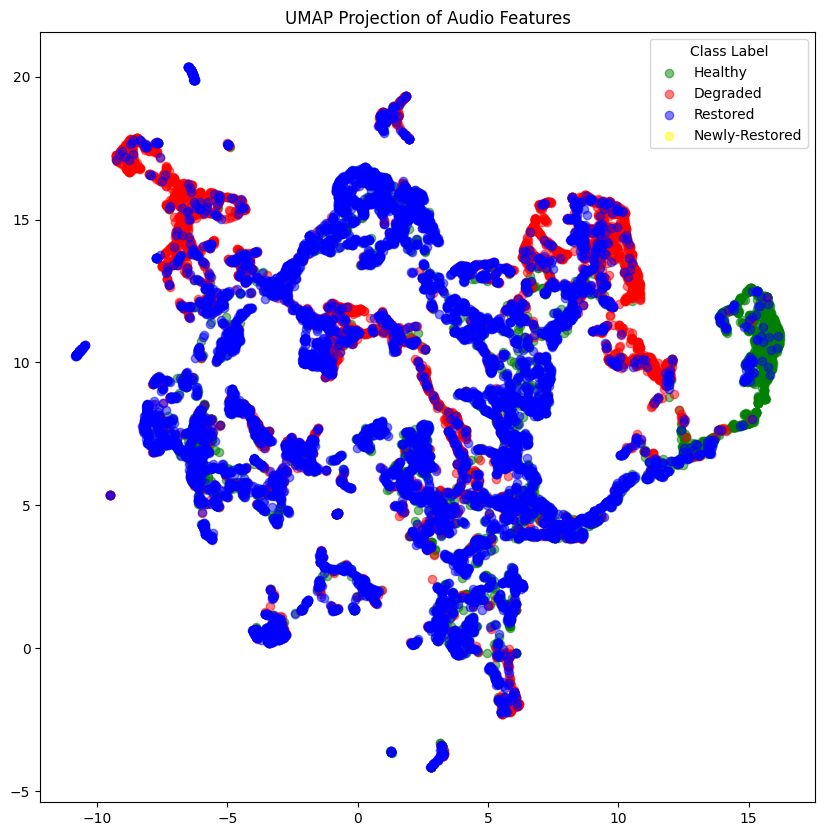

In [318]:
# Mapping from single letters to words for descriptive labels
class_mapping = {'H': 'Healthy', 'D': 'Degraded', 'R': 'Restored', 'N': 'Newly-Restored'}
color_mapping = {'Healthy': 'green', 'Degraded': 'red', 'Restored': 'blue', 'Newly-Restored' : 'yellow'}

# Set up the plot
plt.figure(figsize=(10, 10))

# Plot each class with its own color and label using the mapping
for class_type, label in class_mapping.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = filtered_df['class_type'] == class_type
    plt.scatter(reduced_features_2d2[indices, 0], reduced_features_2d2[indices, 1], label=label,
                color=color_mapping[label], alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection of Audio Features')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()

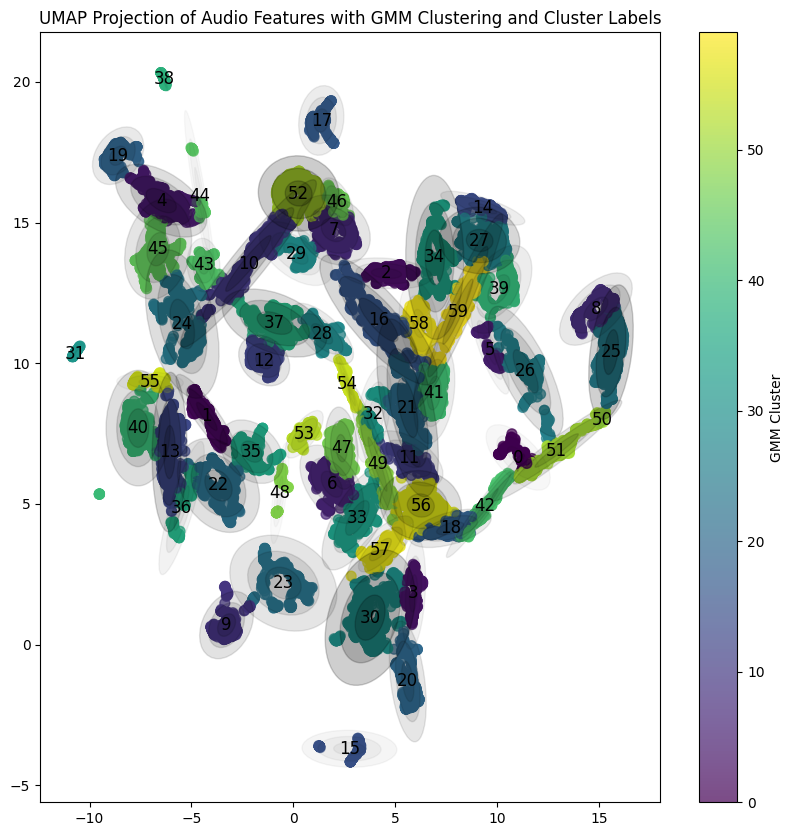

In [338]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Step 1: Fit GMM on the 2D UMAP embeddings
n_components = 60  # Set the number of clusters (you can adjust this based on your data)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_seed)
gmm.fit(reduced_features_2d2)

# Step 2: Predict the cluster labels for each point
gmm_labels = gmm.predict(reduced_features_2d2)

# Step 3: Function to draw ellipses representing GMM components
def draw_ellipse(position, covariance, ax=None, cluster_num=None, **kwargs):
    """Draw an ellipse with a given position and covariance and label it with the cluster number."""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse with angle as a keyword argument
    for nsig in range(1, 4):  # Draw ellipses at 1, 2, and 3 standard deviations
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))
    
    # Add the cluster number at the center of the ellipse
    if cluster_num is not None:
        ax.text(position[0], position[1], str(cluster_num), color='black', fontsize=12, ha='center', va='center')

# Step 4: Plot UMAP embeddings with clusters from GMM
plt.figure(figsize=(10, 10))

# Plot UMAP embeddings and color them by the GMM cluster labels
plt.scatter(reduced_features_2d2[:, 0], reduced_features_2d2[:, 1], c=gmm_labels, cmap='viridis', s=50, alpha=0.7)

# Step 5: Plot GMM ellipses with cluster numbers
w_factor = 0.2 / gmm.weights_.max()  # Scale the ellipses by their weights
for i, (pos, covar, w) in enumerate(zip(gmm.means_, gmm.covariances_, gmm.weights_)):
    draw_ellipse(pos, covar, alpha=w * w_factor, color='black', cluster_num=i)  # Add cluster number

plt.title('UMAP Projection of Audio Features with GMM Clustering and Cluster Labels')
plt.colorbar(label='GMM Cluster')
plt.show()


In [332]:
filtered_df.loc[:, 'cluster'] = gmm_labels
filtered_df

,filename,class_type,0,1,2,3,4,5,6,7,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
0,Indonesia_ROI/clip_ind_D1_20220829_120000_0.wav,D,-0.027101,-0.076875,-0.063106,0.032776,-0.128390,0.136482,0.139281,-0.020360,...,-0.036628,0.089414,-0.059290,-0.013971,-0.010311,-0.015603,0.004040,0.004900,0.047447,13
2,Indonesia_ROI/clip_ind_D1_20220829_130000_3.wav,D,0.076208,-0.006164,-0.071892,-0.009540,-0.164359,0.113579,0.255701,-0.009470,...,-0.027000,0.027038,-0.025422,-0.007529,0.013441,-0.091270,-0.008261,0.024753,0.020466,20
3,Indonesia_ROI/clip_ind_D1_20220829_133800_0.wav,D,-0.018631,-0.034017,-0.046339,-0.008619,-0.102244,0.154953,0.137440,-0.002801,...,-0.074416,0.032068,-0.019790,-0.015040,-0.000246,0.022408,-0.006491,-0.009394,0.036871,39
4,Indonesia_ROI/clip_ind_D1_20220829_141400_9.wav,D,0.051516,-0.037551,-0.027426,0.022241,-0.126988,0.112052,0.155293,0.006822,...,0.029606,0.245155,-0.011603,-0.022627,0.018287,0.009013,-0.033843,0.051912,0.028696,39
5,Indonesia_ROI/clip_ind_D1_20220829_144600_1.wav,D,0.086814,0.007364,0.039778,-0.016533,-0.109143,0.084214,0.151655,0.015705,...,-0.037960,0.231141,-0.052879,-0.014241,0.000537,0.099127,-0.040683,0.074440,0.010627,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38635,Indonesia_ROI/clip_ind_R6_20220923_074200_5.wav,R,0.026358,-0.009309,-0.049600,0.065156,-0.152420,0.139925,0.110636,-0.005117,...,-0.098897,0.188489,-0.041181,0.009082,0.012071,0.031566,-0.013771,0.138063,0.049329,5
38637,Indonesia_ROI/clip_ind_R6_20220923_084000_0.wav,R,-0.009442,-0.019671,-0.073311,0.040517,-0.157533,0.139587,0.146487,-0.035328,...,-0.068740,0.094621,-0.090992,-0.022261,0.014381,0.021919,-0.018332,0.045196,0.028759,20
38638,Indonesia_ROI/clip_ind_R6_20220923_085600_5.wav,R,-0.003106,-0.046812,-0.005686,0.019535,-0.178058,0.093484,0.228089,-0.037534,...,-0.014122,0.108430,-0.090925,-0.009980,0.013957,0.062566,-0.025443,0.011121,0.018234,13
38639,Indonesia_ROI/clip_ind_R6_20220923_092000_8.wav,R,0.081046,-0.041044,0.019907,0.081121,-0.121218,0.060793,0.078691,0.001169,...,-0.089662,0.401369,-0.013633,-0.015444,0.012142,0.004426,-0.031607,0.107869,-0.001309,11


In [333]:
import os
import shutil
import pandas as pd
import random

def organize_clips_by_cluster(df, source_base_folder, destination_base_folder, n_samples):
    """
    Organizes a specified number of audio clips into folders based on their cluster by copying the files.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the data with columns ['filename', 'cluster'].
    source_base_folder (str): Path to the folder containing the source audio files.
    destination_base_folder (str): Path to the folder where cluster folders will be created.
    n_samples (int): The number of random samples to copy into each cluster folder.

    The function creates a folder for each cluster in the specified base folder and copies the selected files into those folders.
    """
    
    # Create the destination base folder if it doesn't exist
    if not os.path.exists(destination_base_folder):
        os.makedirs(destination_base_folder)
    
    # Iterate through each cluster in the DataFrame
    for cluster in df['cluster'].unique():
        # Filter the DataFrame for the current cluster
        cluster_df = df[df['cluster'] == cluster]
        
        # Randomly select `n_samples` files from the current cluster
        selected_files = cluster_df.sample(min(n_samples, len(cluster_df)), random_state=42)
        
        # Create a folder for the current cluster
        cluster_folder = os.path.join(destination_base_folder, f"cluster_{cluster}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        
        # Iterate through the selected files and copy them
        for _, row in selected_files.iterrows():
            source_file = os.path.join(source_base_folder, row['filename'])
            destination_file = os.path.join(cluster_folder, os.path.basename(row['filename']))
            
            # Copy the file to the appropriate cluster folder
            shutil.copy2(source_file, destination_file)
            print(f"Copied {source_file} to {destination_file}")



source_base_folder = "/mnt/d/Aqoustics/BEN/"
destination_base_folder = "/mnt/d/Aqoustics/BEN/Indonesia_Clusters/"
n_samples = 5
organize_clips_by_cluster(filtered_df, source_base_folder, destination_base_folder,n_samples)

Copied /mnt/d/Aqoustics/BEN/Indonesia_ROI/clip_ind_R4_20220917_124000_8.wav to /mnt/d/Aqoustics/BEN/Indonesia_Clusters/cluster_13/clip_ind_R4_20220917_124000_8.wav
Copied /mnt/d/Aqoustics/BEN/Indonesia_ROI/clip_ind_R4_20220920_072400_7.wav to /mnt/d/Aqoustics/BEN/Indonesia_Clusters/cluster_13/clip_ind_R4_20220920_072400_7.wav
Copied /mnt/d/Aqoustics/BEN/Indonesia_ROI/clip_ind_R3_20220919_132800_5.wav to /mnt/d/Aqoustics/BEN/Indonesia_Clusters/cluster_13/clip_ind_R3_20220919_132800_5.wav
Copied /mnt/d/Aqoustics/BEN/Indonesia_ROI/clip_ind_D2_20220921_163600_1.wav to /mnt/d/Aqoustics/BEN/Indonesia_Clusters/cluster_13/clip_ind_D2_20220921_163600_1.wav
Copied /mnt/d/Aqoustics/BEN/Indonesia_ROI/clip_ind_D1_20220829_133800_1.wav to /mnt/d/Aqoustics/BEN/Indonesia_Clusters/cluster_13/clip_ind_D1_20220829_133800_1.wav
Copied /mnt/d/Aqoustics/BEN/Indonesia_ROI/clip_ind_D5_20220831_055000_0.wav to /mnt/d/Aqoustics/BEN/Indonesia_Clusters/cluster_20/clip_ind_D5_20220831_055000_0.wav
Copied /mnt/d/Aq